In [4]:
from time import time
import logging
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# Load the dataset
lfw_people = fetch_lfw_people(min_faces_per_person = 70, resize = 0.4)

# Introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly ( as relative pixel)
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]


# Print the dataset size
print('Total dataset size:')
print('n_samples: %d' % n_samples)
print('n_features: %d' % n_features)
print('n_classes: %d' % n_classes)
print('Height: %d' % h)
print('Width: %d' % w)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7
Height: 50
Width: 37


In [5]:
x_vals = np.reshape(X, X.shape + (1,))
# x_vals.ndim
# x_vals.shape
new_dim = x_vals.reshape(x_vals.shape[0], h, w,x_vals.shape[2])
new_dim.shape

(1288, 50, 37, 1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    new_dim, y, test_size=0.25, random_state=42)

In [7]:
print(X_train.shape)
print(X_test.shape)

(966, 50, 37, 1)
(322, 50, 37, 1)


In [9]:
X_train = X_train/255.0
X_test = X_test/255.0

In [10]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [11]:
model = Sequential()

model.add(Conv2D(filters = 8, kernel_size = (4,4), padding = 'Same',
                activation = 'relu', input_shape = ( h, w, 1)))
model.add(MaxPool2D(pool_size = (2,2,)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 16, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), strides = (2,2)))
model.add(Dropout(0.25))

#fully connected
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation = 'softmax'))

# Print the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 37, 8)         136       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 18, 8)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 25, 18, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 18, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 9, 16)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 12, 9, 16)         0

2022-06-03 23:15:36.022139: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
optimizer = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)

/Users/test/opt/anaconda3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [13]:
# Compile the model
model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

# Epochs and Batch Size

epochs = 500
batch_size = 22

# Data Augmentation
datagen = ImageDataGenerator(
    featurewise_center = True, # set input mean to 0 over the dataset
    samplewise_center = False, # set each sample mean to 0
    featurewise_std_normalization = True, # divide inputs by std of the dataset
    samplewise_std_normalization = False, # divide each inputs by its std
    zca_whitening = False, # dimension reduction
    rotation_range = 20, # randomly rotate images in the range 5 degrees
    zoom_range = 0.1, # Randomly zoom image 10%
    width_shift_range = 0.2, # randomly shift images horizontally 10%
    height_shift_range = 0.2, # randomly shift images vertically 10%
    horizontal_flip = True, # randomly flip images
    vertical_flip = 0.2 # Random flip images
)
datagen.fit(X_train)
#datagen.fit(X_train.reshape(n_samples, h, w, 1)

history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                             epochs = epochs, validation_data = (X_test, y_test), 
                              steps_per_epoch = X_train.shape[0] // batch_size)

Epoch 1/500


/var/folders/kk/6xprygb52ml2mc2lwt6gjv040000gn/T/ipykernel_1691/3630735002.py:26: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),


43/43 [==============================] - 2s 33ms/step - loss: 1.9146 - accuracy: 0.3655 - val_loss: 2.1103 - val_accuracy: 0.4534
Epoch 2/500
43/43 [==============================] - 1s 32ms/step - loss: 1.7713 - accuracy: 0.3739 - val_loss: 2.0511 - val_accuracy: 0.4534
Epoch 3/500
43/43 [==============================] - 1s 27ms/step - loss: 1.7467 - accuracy: 0.3909 - val_loss: 1.9222 - val_accuracy: 0.4534
Epoch 4/500
43/43 [==============================] - 1s 28ms/step - loss: 1.7389 - accuracy: 0.3856 - val_loss: 1.9737 - val_accuracy: 0.4534
Epoch 5/500
43/43 [==============================] - 2s 38ms/step - loss: 1.7112 - accuracy: 0.3951 - val_loss: 1.9908 - val_accuracy: 0.4534
Epoch 6/500
43/43 [==============================] - 1s 25ms/step - loss: 1.7047 - accuracy: 0.4121 - val_loss: 1.8414 - val_accuracy: 0.4534
Epoch 7/500
43/43 [==============================] - 1s 32ms/step - loss: 1.6972 - accuracy: 0.3898 - val_loss: 1.8198 - val_accuracy: 0.4534
Epoch 8/500
43/43 

43/43 [==============================] - 1s 24ms/step - loss: 1.1594 - accuracy: 0.5816 - val_loss: 1.7150 - val_accuracy: 0.4534
Epoch 59/500
43/43 [==============================] - 1s 24ms/step - loss: 1.1727 - accuracy: 0.5900 - val_loss: 1.7307 - val_accuracy: 0.4534
Epoch 60/500
43/43 [==============================] - 1s 24ms/step - loss: 1.1923 - accuracy: 0.5816 - val_loss: 1.7587 - val_accuracy: 0.4534
Epoch 61/500
43/43 [==============================] - 1s 24ms/step - loss: 1.1381 - accuracy: 0.5858 - val_loss: 1.7492 - val_accuracy: 0.4534
Epoch 62/500
43/43 [==============================] - 1s 23ms/step - loss: 1.1414 - accuracy: 0.6049 - val_loss: 1.6979 - val_accuracy: 0.4565
Epoch 63/500
43/43 [==============================] - 1s 24ms/step - loss: 1.1233 - accuracy: 0.6102 - val_loss: 1.7911 - val_accuracy: 0.4565
Epoch 64/500
43/43 [==============================] - 1s 24ms/step - loss: 1.1595 - accuracy: 0.5805 - val_loss: 1.8318 - val_accuracy: 0.4627
Epoch 65/500

43/43 [==============================] - 1s 25ms/step - loss: 1.0207 - accuracy: 0.6600 - val_loss: 1.8004 - val_accuracy: 0.4565
Epoch 116/500
43/43 [==============================] - 1s 24ms/step - loss: 1.0250 - accuracy: 0.6525 - val_loss: 1.9871 - val_accuracy: 0.4534
Epoch 117/500
43/43 [==============================] - 1s 24ms/step - loss: 1.0333 - accuracy: 0.6345 - val_loss: 1.7080 - val_accuracy: 0.4534
Epoch 118/500
43/43 [==============================] - 1s 23ms/step - loss: 1.0207 - accuracy: 0.6504 - val_loss: 1.6629 - val_accuracy: 0.4472
Epoch 119/500
43/43 [==============================] - 1s 24ms/step - loss: 0.9793 - accuracy: 0.6674 - val_loss: 1.7238 - val_accuracy: 0.4565
Epoch 120/500
43/43 [==============================] - 1s 24ms/step - loss: 0.9637 - accuracy: 0.6621 - val_loss: 1.7746 - val_accuracy: 0.4627
Epoch 121/500
43/43 [==============================] - 1s 24ms/step - loss: 0.9736 - accuracy: 0.6547 - val_loss: 1.8146 - val_accuracy: 0.4565
Epoch 

Epoch 172/500
43/43 [==============================] - 1s 25ms/step - loss: 0.9114 - accuracy: 0.6674 - val_loss: 2.1756 - val_accuracy: 0.4596
Epoch 173/500
43/43 [==============================] - 1s 24ms/step - loss: 0.9061 - accuracy: 0.6833 - val_loss: 1.8576 - val_accuracy: 0.4565
Epoch 174/500
43/43 [==============================] - 1s 24ms/step - loss: 0.8826 - accuracy: 0.7013 - val_loss: 1.9394 - val_accuracy: 0.4596
Epoch 175/500
43/43 [==============================] - 1s 24ms/step - loss: 0.8814 - accuracy: 0.6843 - val_loss: 1.8656 - val_accuracy: 0.4565
Epoch 176/500
43/43 [==============================] - 1s 25ms/step - loss: 0.9367 - accuracy: 0.6886 - val_loss: 2.0155 - val_accuracy: 0.4565
Epoch 177/500
43/43 [==============================] - 1s 25ms/step - loss: 0.9055 - accuracy: 0.6515 - val_loss: 2.0916 - val_accuracy: 0.4565
Epoch 178/500
43/43 [==============================] - 1s 25ms/step - loss: 0.8733 - accuracy: 0.6864 - val_loss: 2.1326 - val_accuracy:

Epoch 229/500
43/43 [==============================] - 1s 23ms/step - loss: 0.8530 - accuracy: 0.7087 - val_loss: 2.1479 - val_accuracy: 0.4534
Epoch 230/500
43/43 [==============================] - 1s 24ms/step - loss: 0.8781 - accuracy: 0.6886 - val_loss: 2.1309 - val_accuracy: 0.4534
Epoch 231/500
43/43 [==============================] - 1s 23ms/step - loss: 0.8450 - accuracy: 0.7066 - val_loss: 2.0222 - val_accuracy: 0.4534
Epoch 232/500
43/43 [==============================] - 1s 24ms/step - loss: 0.8635 - accuracy: 0.6769 - val_loss: 2.5799 - val_accuracy: 0.4534
Epoch 233/500
43/43 [==============================] - 1s 24ms/step - loss: 0.8403 - accuracy: 0.6939 - val_loss: 2.3477 - val_accuracy: 0.4534
Epoch 234/500
43/43 [==============================] - 1s 24ms/step - loss: 0.7864 - accuracy: 0.7235 - val_loss: 2.4655 - val_accuracy: 0.4534
Epoch 235/500
43/43 [==============================] - 1s 24ms/step - loss: 0.8324 - accuracy: 0.7129 - val_loss: 2.2034 - val_accuracy:

Epoch 286/500
43/43 [==============================] - 1s 24ms/step - loss: 0.8046 - accuracy: 0.7119 - val_loss: 2.0044 - val_accuracy: 0.4503
Epoch 287/500
43/43 [==============================] - 1s 23ms/step - loss: 0.7941 - accuracy: 0.7267 - val_loss: 1.9712 - val_accuracy: 0.4565
Epoch 288/500
43/43 [==============================] - 1s 24ms/step - loss: 0.8076 - accuracy: 0.7235 - val_loss: 2.0692 - val_accuracy: 0.4534
Epoch 289/500
43/43 [==============================] - 1s 24ms/step - loss: 0.8500 - accuracy: 0.7140 - val_loss: 2.1199 - val_accuracy: 0.4503
Epoch 290/500
43/43 [==============================] - 1s 24ms/step - loss: 0.7816 - accuracy: 0.7193 - val_loss: 2.1261 - val_accuracy: 0.4534
Epoch 291/500
43/43 [==============================] - 1s 24ms/step - loss: 0.7752 - accuracy: 0.7161 - val_loss: 2.2476 - val_accuracy: 0.4596
Epoch 292/500
43/43 [==============================] - 1s 24ms/step - loss: 0.8154 - accuracy: 0.6992 - val_loss: 2.1509 - val_accuracy:

Epoch 343/500
43/43 [==============================] - 1s 24ms/step - loss: 0.7266 - accuracy: 0.7500 - val_loss: 2.1184 - val_accuracy: 0.4410
Epoch 344/500
43/43 [==============================] - 1s 24ms/step - loss: 0.7679 - accuracy: 0.7458 - val_loss: 2.1301 - val_accuracy: 0.4472
Epoch 345/500
43/43 [==============================] - 1s 24ms/step - loss: 0.7715 - accuracy: 0.7225 - val_loss: 1.9935 - val_accuracy: 0.4565
Epoch 346/500
43/43 [==============================] - 1s 23ms/step - loss: 0.7269 - accuracy: 0.7426 - val_loss: 2.0466 - val_accuracy: 0.4596
Epoch 347/500
43/43 [==============================] - 1s 24ms/step - loss: 0.7460 - accuracy: 0.7288 - val_loss: 2.3192 - val_accuracy: 0.4565
Epoch 348/500
43/43 [==============================] - 1s 24ms/step - loss: 0.7569 - accuracy: 0.7320 - val_loss: 2.1108 - val_accuracy: 0.4130
Epoch 349/500
43/43 [==============================] - 1s 23ms/step - loss: 0.7879 - accuracy: 0.7076 - val_loss: 2.1214 - val_accuracy:

Epoch 400/500
43/43 [==============================] - 1s 24ms/step - loss: 0.6999 - accuracy: 0.7553 - val_loss: 2.3420 - val_accuracy: 0.4565
Epoch 401/500
43/43 [==============================] - 1s 24ms/step - loss: 0.7262 - accuracy: 0.7564 - val_loss: 2.1759 - val_accuracy: 0.4596
Epoch 402/500
43/43 [==============================] - 1s 23ms/step - loss: 0.7835 - accuracy: 0.7256 - val_loss: 2.1246 - val_accuracy: 0.4565
Epoch 403/500
43/43 [==============================] - 1s 24ms/step - loss: 0.7404 - accuracy: 0.7479 - val_loss: 1.9801 - val_accuracy: 0.4503
Epoch 404/500
43/43 [==============================] - 1s 24ms/step - loss: 0.7582 - accuracy: 0.7383 - val_loss: 2.0370 - val_accuracy: 0.4565
Epoch 405/500
43/43 [==============================] - 1s 24ms/step - loss: 0.7008 - accuracy: 0.7722 - val_loss: 2.1371 - val_accuracy: 0.4503
Epoch 406/500
43/43 [==============================] - 1s 24ms/step - loss: 0.7585 - accuracy: 0.7235 - val_loss: 2.1867 - val_accuracy:

Epoch 457/500
43/43 [==============================] - 1s 24ms/step - loss: 0.6785 - accuracy: 0.7564 - val_loss: 2.2355 - val_accuracy: 0.3137
Epoch 458/500
43/43 [==============================] - 1s 25ms/step - loss: 0.6795 - accuracy: 0.7500 - val_loss: 2.1309 - val_accuracy: 0.4161
Epoch 459/500
43/43 [==============================] - 1s 25ms/step - loss: 0.7529 - accuracy: 0.7500 - val_loss: 2.2077 - val_accuracy: 0.4193
Epoch 460/500
43/43 [==============================] - 1s 24ms/step - loss: 0.7146 - accuracy: 0.7606 - val_loss: 2.1413 - val_accuracy: 0.4379
Epoch 461/500
43/43 [==============================] - 1s 24ms/step - loss: 0.6823 - accuracy: 0.7659 - val_loss: 2.1334 - val_accuracy: 0.4286
Epoch 462/500
43/43 [==============================] - 1s 24ms/step - loss: 0.7726 - accuracy: 0.7267 - val_loss: 2.0921 - val_accuracy: 0.3882
Epoch 463/500
43/43 [==============================] - 1s 24ms/step - loss: 0.7143 - accuracy: 0.7500 - val_loss: 2.0880 - val_accuracy:

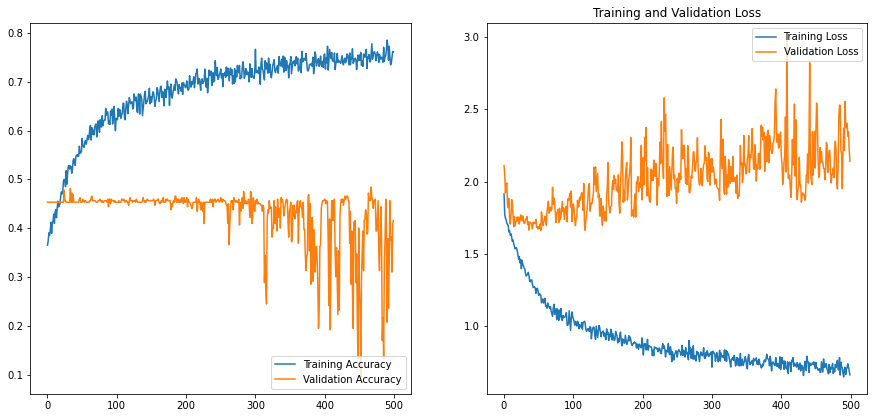

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(500)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 41.61%
